In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import sys
sys.path.append("../src")
import utils.data_preparation as dp
import utils.metrics as metrics
from models import siamese

In [139]:
# read data
data = np.load("../Data/RayTracingData/Remcom_4x4_IR_100taps.npy")
rx_positions = np.load("../Data/RayTracingData/Remcom_4x4_rxpos.npy")
true_pos = rx_positions[:,:2]

In [140]:
data.shape , true_pos.shape

((23922, 16, 100), (23922, 2))

We observe that a lot of information is contained on the imaginary part of the impulse. So the 16 antennas, we are gong to have 32 'Channels' for our dataset. 
So we will have a training batch of shape [batch_size, 32 , 100].

# Siamese Neural Network

In [133]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Setting up the Custom Dataset

In [171]:
# undersampling
idces = np.random.randint(0, data.shape[0], int(0.1*data.shape[0]))
data_undersampled = data[idces]
true_pos_undersampled = true_pos[idces]

In [172]:
data_undersampled.shape

(2392, 16, 100)

In [173]:
data_undersampled.shape
# train test split
train_X, test_X= train_test_split(data_undersampled)
train_y, test_y= train_test_split(true_pos_undersampled)

In [175]:
train_dataset = dp.SiameseDataset(train_X, train_y)
scaler_X = train_dataset.scaler_real, train_dataset.scaler_imag
scaler_y = train_dataset.scaler_y
test_dataset = dp.SiameseDataset(test_X, test_y, scaler_X, scaler_y)

In [176]:
train_dataset.nb_channels()

32

In [178]:
class SimpleNN(nn.Module):
    def __init__(self, dropout):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=train_dataset.nb_channels(),
                          out_channels=128,
                          kernel_size=32,
                          stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(in_channels=128, 
                          out_channels=64,
                          kernel_size=16,
                          stride=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64,
                          out_channels=16,
                          kernel_size=8,
                          stride=2)
        self.bn3 = nn.BatchNorm1d(16)
        
        f = siamese.conv1d_output_size
        self.features = f(f(f(train_dataset.nb_samples(),kernel_size=32, stride=2),
                                                       kernel_size=16, stride=2), 
                                                         kernel_size=8, stride=2)

        
        
        self.lin1 = nn.Linear(in_features= 16 * self.features, out_features=128)
        self.lin2 = nn.Linear(in_features=128, out_features=32)
        self.lin3 = nn.Linear(in_features=32, out_features=8)
        self.lin4 = nn.Linear(in_features=8, out_features=2)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.lin1(x)))
        x = self.dropout(F.relu(self.lin2(x)))
        x = self.dropout(F.relu(self.lin3(x)))
        
        out = self.lin4(x)
        
        return out
        
    

In [179]:
dropout = 0.3
model = SimpleNN(dropout)

In [181]:
def loss_function(x1, x2, y1, y2):
    return torch.sum((torch.dist(x1,x2) - torch.dist(y1, y2))**2/(torch.dist(x1,x2) + 1e-5))

In [182]:
x1, x2 = train_dataset[0:100][0][0], train_dataset[0:100][1][0]
y1, y2 = model(x1), model(x2)

In [183]:
x1.shape[0]

100

## Evaluate results

### Unsupervised Evaluation

#### Trustworthiness

In [165]:
y1 = y1.unsqueeze(2)

In [166]:
y1.shape

torch.Size([100, 2, 1])

In [167]:
tw = np.mean(metrics.trustworthiness(x1, y1))
ct = np.mean(metrics.continuity(x1,y1))

In [168]:
tw ,ct

(1.000217391304348, 0.9961673913043478)

In [169]:
y1 = y1.detach()

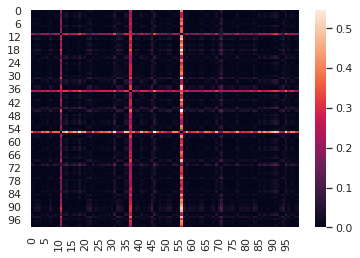

In [124]:
sns.heatmap(metrics.distance_matrix(y1))

In [125]:
metrics.rank_matrix(metrics.distance_matrix(x1))

tensor([[ 0, 45, 58,  ..., 55, 25, 59],
        [ 3,  0, 58,  ..., 55, 24, 59],
        [ 6, 37,  0,  ..., 55, 32, 59],
        ...,
        [ 7, 44, 58,  ...,  0, 27, 59],
        [11, 45, 58,  ..., 55,  0, 59],
        [ 7, 46, 59,  ..., 57, 25,  0]])

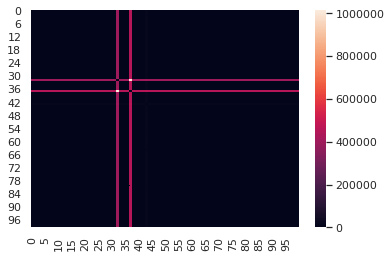

In [126]:
sns.heatmap(metrics.distance_matrix(x1))

In [127]:
ct = metrics.continuity(x1, y1)

In [128]:
tw = metrics.trustworthiness(x1,y1)

In [129]:
np.mean(ct), np.mean(tw)

(0.9950336956521739, 1.000217391304348)

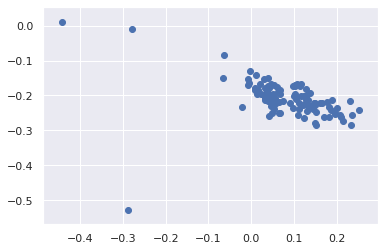

In [130]:
plt.scatter(y1[:,0], y1[:,1])

In [132]:
rx_positions

array([[   4.46871614, -159.38421631,    2.        ],
       [   6.96871614, -159.38421631,    2.        ],
       [   9.46871614, -159.38421631,    2.        ],
       ...,
       [ 464.46871614,  278.11578369,    2.        ],
       [ 466.96871614,  278.11578369,    2.        ],
       [ 469.46871614,  278.11578369,    2.        ]])

In [30]:
example_1= test_dataset[0:1][0]
example_2= test_dataset[11:12][0]

example_1.shape, example_2.shape

(torch.Size([1, 32, 100]), torch.Size([1, 32, 100]))

In [31]:
example_1_mapping, example_2_mapping = model(example_1), model(example_2)

In [32]:
example_1_mapping, example_2_mapping

(tensor([[ 0.1229, -0.2402]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1844, -0.1774]], grad_fn=<AddmmBackward>))

In [33]:
loss_function(example_1, example_2, example_1_mapping, example_2_mapping)

tensor(30.7645, grad_fn=<SumBackward0>)

In [34]:
example_1_mapping, example_2_mapping

(tensor([[ 0.1229, -0.2402]], grad_fn=<AddmmBackward>),
 tensor([[ 0.1844, -0.1774]], grad_fn=<AddmmBackward>))

In [35]:
mappings = model(test_dataset[:][0]).detach().numpy()

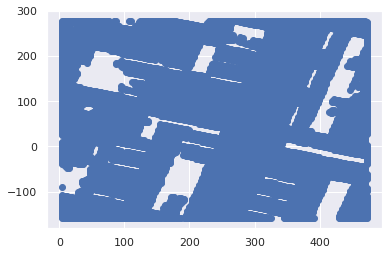

In [65]:
plt.scatter(rx_positions[:,0], rx_positions[:,1], label='True')
ax.legend()

In [83]:
torch.mean((y1[:,:-1] - true_pos[:100])**2)

tensor(23674.7879, dtype=torch.float64)